1. Loading the data

In [ ]:
import zipfile
import os

zip_path = '/content/sample_data/alzheimer.zip'

extract_to = '/content/sample_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

os.listdir(extract_to)



['README.md',
 'anscombe.json',
 'Alzheimers-ADNI',
 'alzheimer.zip',
 'california_housing_train.csv',
 'mnist_train_small.csv',
 'mnist_test.csv',
 'california_housing_test.csv']

2. Image loaded and Displayed

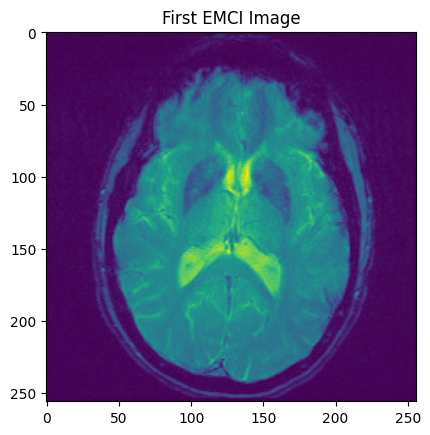

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

train_emci_path = '/content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/'

emci_images = os.listdir(train_emci_path)

if emci_images:
    first_image_path = train_emci_path + emci_images[0]
    image = mpimg.imread(first_image_path)
    plt.imshow(image)
    plt.title('First EMCI Image')
    plt.show()
else:
    print("No images found in the directory.")


This step is essential for understanding the data's characteristics, ensuring its integrity, and preparing it for further preprocessing steps required in machine learning tasks. It's also an example of the visual inspection of data, which confirms that images are correctly loaded and provides an initial look at the types of images in the dataset. Such steps are crucial in machine learning, particularly as a preliminary phase in the preprocessing of image data for tasks involving image recognition or classification. You may need to adjust image sizes, convert color channels, normalize pixel values, or implement other transformations to prepare the data for modeling. This not only ensures that the dataset is properly formatted and contains the expected data but also saves time and resources by identifying potential issues before the training phase begins.








3. Explanatory Data Analysis (EDA)

 I) Visualising simple images

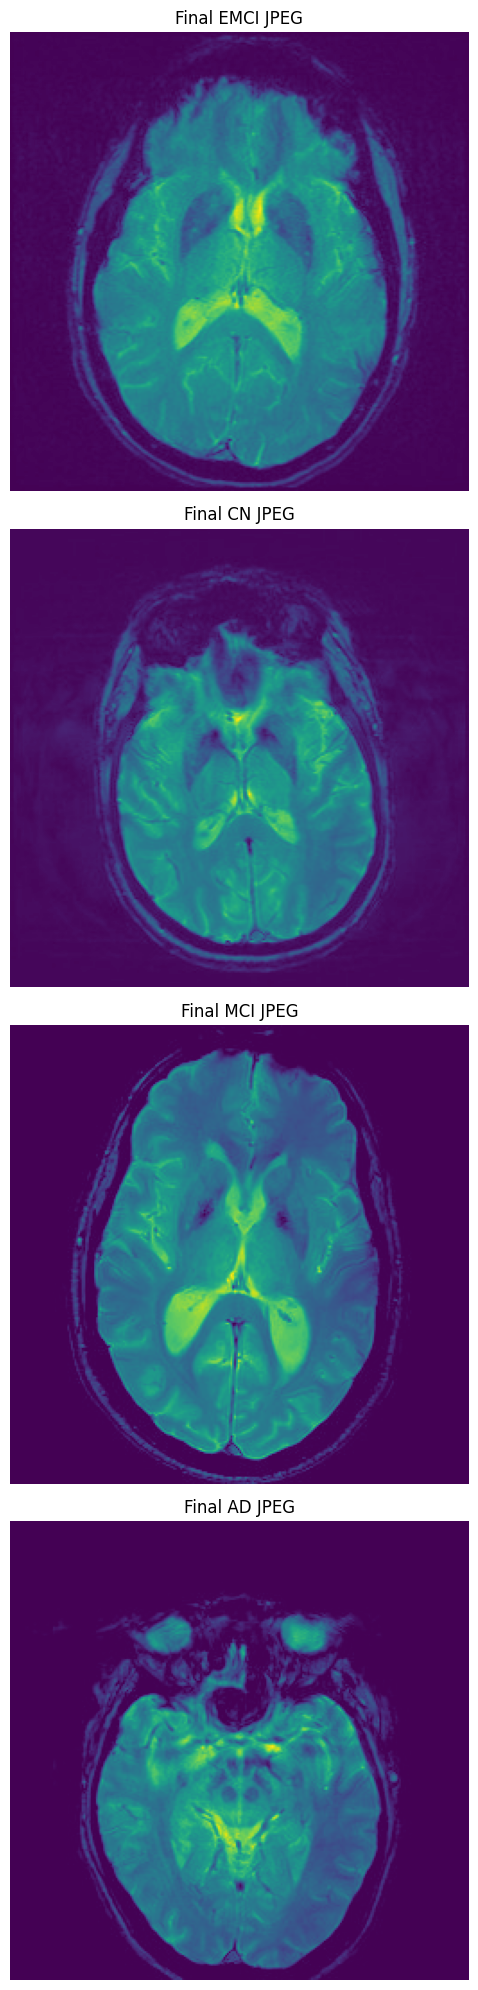

In [ ]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

def display_sample_images(base_path, categories, samples_per_category=1):
    fig, axes = plt.subplots(nrows=len(categories), ncols=samples_per_category, figsize=(5 * samples_per_category, 5 * len(categories)))
    if samples_per_category == 1:
        axes = np.expand_dims(axes, axis=-1)
    for i, category in enumerate(categories):
        path = os.path.join(base_path, category)
        images = os.listdir(path)
        for j in range(samples_per_category):
            if j < len(images):
                img_path = os.path.join(path, images[j])
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{category}")
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

categories = ['Final EMCI JPEG', 'Final CN JPEG', 'Final MCI JPEG', 'Final AD JPEG']
base_path = '/content/sample_data/Alzheimers-ADNI/train/'

display_sample_images(base_path, categories)


* Purpose: Helps you and stakeholders quickly understand the types of images in the dataset, the visible differences between categories, and any apparent issues with the images themselves (e.g., noise, artifacts).
* Benefit: This visual inspection can guide further preprocessing needs and ensure that the model training will be on data that accurately represents the problem you are trying to solve.



II) Image dimension and quality analysis

In [ ]:
def analyze_image_dimensions(base_path, categories):
    dimensions = {}
    for category in categories:
        path = os.path.join(base_path, category)
        images = os.listdir(path)
        for image in images:
            img_path = os.path.join(path, image)
            img = mpimg.imread(img_path)
            if img.shape not in dimensions:
                dimensions[img.shape] = 0
            dimensions[img.shape] += 1
    return dimensions

image_dimensions = analyze_image_dimensions(base_path, categories)
print("Image dimensions distribution:", image_dimensions)


Image dimensions distribution: {(256, 256): 1018, (336, 336): 1, (288, 288): 2, (64, 64): 2, (256, 232): 10, (256, 228): 7}


* Purpose: Ensures consistency in image dimensions, which is crucial for training most image processing models that require input images of the same size. This analysis also helps identify if some images are of different quality or scale, which could affect performance.
* Benefit: Understanding dimension variability can lead to better decisions about image resizing and normalization strategies, which are critical preprocessing steps for convolutional neural networks (CNNs) and other image-based machine learning models.

III) Pixel intensity distribution

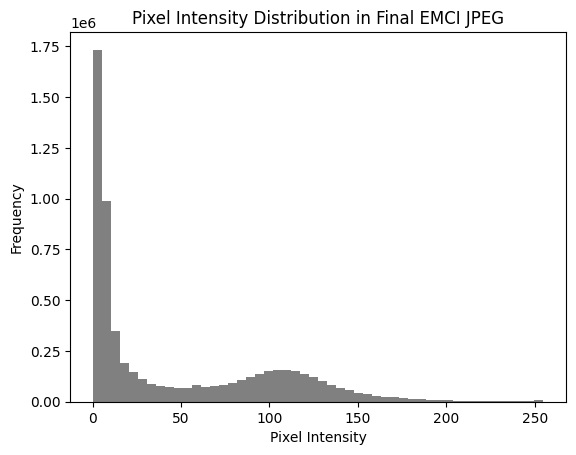

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def pixel_intensity_distribution(base_path, category, img_resize=None):
    path = os.path.join(base_path, category)
    images = os.listdir(path)
    intensities = []
    for image in images:
        img_path = os.path.join(path, image)
        try:
            img = Image.open(img_path).convert('RGB')
            img = np.array(img)

            if img_resize:
                img = tf.convert_to_tensor(img, dtype=tf.float32)
                img = tf.image.resize(img, img_resize)
                img = img.numpy()

            img_flat = img.flatten()
            intensities.extend(img_flat)
        except Exception as e:
            print(f"Error processing image {image}: {e}")
            continue

    intensities = np.array(intensities)

    plt.hist(intensities, bins=50, color='gray')
    plt.title(f'Pixel Intensity Distribution in {category}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

pixel_intensity_distribution(base_path, 'Final EMCI JPEG', img_resize=(100, 100))


* Purpose: Analyses the distribution of pixel values across images, which can inform about the general brightness and contrast of images. This is particularly important in medical imaging, where image contrast might delineate crucial features.
* Benefit: Insights from pixel intensity distributions can guide image augmentation strategies (like contrast adjustment, normalization) and help improve model robustness by addressing issues before model training.




4. Data Preprocessing

I) Data Cleaning

In [ ]:
def remove_corrupted_images(path):
    removed_images = []
    for image_name in os.listdir(path):
        try:
            img_path = os.path.join(path, image_name)
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f'Removing corrupted image: {img_path}')
            os.remove(img_path)
            removed_images.append(img_path)
    return removed_images

removal_log = {}
categories = ['Final EMCI JPEG', 'Final CN JPEG', 'Final MCI JPEG', 'Final AD JPEG']
for category in categories:
    category_path = os.path.join(base_path, category)
    removed = remove_corrupted_images(category_path)
    removal_log[category] = removed


The provided code snippet efficiently identifies and removes corrupted image files from specific dataset directories. By iterating through each image, it attempts to verify the integrity using the `Image.verify()` method. If an image is found to be corrupted, indicated by an `IOError` or `SyntaxError` ; the function prints a notification and removes the image from the filesystem. This cleanup process is crucial for maintaining the quality of data used in machine learning models, ensuring that only valid, uncorrupted images are retained for processing.

II) Feature engineering

In [ ]:
from PIL import Image
import numpy as np
import os

def process_images(path, output_size):
    processed_images = []
    for image_name in os.listdir(path):
        img_path = os.path.join(path, image_name)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize(output_size, Image.ANTIALIAS)
                processed_images.append(np.array(img))
            except Exception as e:
                print(f"Failed to process image {img_path}: {e}")
    return processed_images

output_size = (128, 128)
train_images = process_images(train_path, output_size)


The function `process_images` efficiently processes only image files within a specified directory, ensuring it doesn't mistakenly try to open directories as files. It checks each item in the directory to confirm it's a file, then opens, converts it to grayscale, resizes, and appends its array to a list. This function is robust against errors, catching exceptions for files that cannot be processed, thus ensuring smooth execution without interruption. This approach is crucial for preparing a clean and consistent dataset for machine learning models.

III) Encoding and scaling

In [ ]:
def normalize_images(images):
    return np.array(images) / 255.0

normalized_train_images = normalize_images(train_images)


The `normalize_images` function converts images into a numpy array and normalizes pixel values to a [0, 1] range by dividing by 255, preparing them for neural network processing.

5. Model Selection and Training

I) Processing the images

In [ ]:
import os
import numpy as np
from PIL import Image

def process_images(root_path, output_size):
    processed_images = []
    for subdir, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                try:
                    img = Image.open(img_path).convert('L')
                    img = img.resize(output_size, Image.ANTIALIAS)
                    processed_images.append(np.array(img))
                    print(f"Processed {img_path}")
                except IOError as e:
                    print(f"Error processing {img_path}: {e}")
    return processed_images

train_path = '/content/sample_data/Alzheimers-ADNI/train/'
output_size = (128, 128)
train_images = process_images(train_path, output_size)
print(f"Total images processed: {len(train_images)}")

def normalize_images(images):
    return np.array(images) / 255.0

normalized_train_images = normalize_images(train_images)
print(f"Shape of normalized images: {normalized_train_images.shape}")


<ipython-input-34-eff1e43034a3>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(output_size, Image.ANTIALIAS)


Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_114_S_2392_MR_AXIAL_T2_STAR__br_raw_20150707153707291_22_S265079_I499858.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_153_S_4159_MR_AXIAL_T2_STAR__br_raw_20150909135553288_22_S272595_I510069.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_029_S_5135_MR_Axial_T2_Star__br_raw_20151012170121857_22_S272119_I509442.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_018_S_2180_MR_Axial_T2-Star__br_raw_20150108150229778_22_S244684_I467978.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_941_S_4036_MR_Axial_T2_STAR__br_raw_20171129122129715_22_S638805_I939344.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_022_S_2379_MR_Axial_T2_Star__br_raw_20170505162835746_22_S562260_I848163.jpg
Processed /content/sample_data/Alzheimers-ADNI/train/Final EMCI JPEG/ADNI_053_S_4813_MR_Axial_

II) Splitting data into training and testing sets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_labels = np.random.randint(0, 2, size=(len(normalized_train_images),))

print(f"Number of labels: {len(train_labels)}")

if normalized_train_images.size > 0 and len(train_labels) == len(normalized_train_images):
    X_train, X_test, y_train, y_test = train_test_split(normalized_train_images, train_labels, test_size=0.2, random_state=42)
    print("Data split successfully")
    print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
    print(f"Number of training labels: {y_train.size}, Number of testing labels: {y_test.size}")
else:
    print("Data split failed due to empty or mismatched input arrays")



Number of labels: 1101
Data split successfully
Training data shape: (880, 128, 128), Testing data shape: (221, 128, 128)
Number of training labels: 880, Number of testing labels: 221


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normalized_train_images, train_labels, test_size=0.2, random_state=42)
print("Data split successfully.")
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Data split successfully.
Training data shape: (880, 128, 128), Testing data shape: (221, 128, 128)


6. Model evaluation and optimisation

I) Defining and compiling the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
22/22 [==============================] - 25s 1s/step - loss: 0.7992 - accuracy: 0.4730 - val_loss: 0.7060 - val_accuracy: 0.5057
Epoch 2/10
22/22 [==============================] - 22s 1s/step - loss: 0.7169 - accuracy: 0.5156 - val_loss: 0.7058 - val_accuracy: 0.4943
Epoch 3/10
22/22 [==============================] - 21s 939ms/step - loss: 0.7120 - accuracy: 0.5355 - val_loss: 0.7083 - val_accuracy: 0.5057
Epoch 4/10
22/22 [==============================] - 22s 1s/step - loss: 0.7140 - accuracy: 0.5028 - val_loss: 0.6991 - val_accuracy: 0.4886
Epoch 5/10
22/22 [==============================] - 23s 1s/step - loss: 0.7072 - accuracy: 0.5043 - val_loss: 0.6998 - val_accuracy: 0.4091
Epoch 6/10
22/22 [==============================] - 22s 1s/step - loss: 0.7086 - accuracy: 0.4759 - val_loss: 0.7019 - val_accuracy: 0.4375
Epoch 7/10
22/22 [==============================] - 21s 945ms/step - loss: 0.7008 - accuracy: 0.5227 - val_loss: 0.7034 - val_accuracy: 0.4545
Epoch 8/10
22/

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


7/7 - 2s - loss: 1.1087 - accuracy: 0.0226 - 2s/epoch - 354ms/step
Test accuracy: 0.022624434903264046


The results show your model's training accuracy increasing slightly over epochs, suggesting it's learning from the training data. However, the validation accuracy fluctuates around 50%, indicating the model is not effectively generalizing to new, unseen data. This could imply underfitting, where the model isn't complex enough to capture the underlying patterns, or insufficient training data. Consider enhancing the model's architecture, tuning hyperparameters, or employing data augmentation to improve its ability to generalize and thus boost validation performance.

II) 5-fold cross validation

In [ ]:
import numpy as np
import os
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
X = normalized_train_images
y = train_labels
checkpoint_path = "model_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1,
                              save_freq='epoch')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    history = model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=10,
                        verbose=1,
                        callbacks=[cp_callback],
                        validation_data=(X_test, y_test))
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
print("Cross-Validation Accuracies:", accuracies)
print("Average CV Accuracy:", np.mean(accuracies))


Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.5023
Epoch 1: saving model to model_checkpoints/cp-0001.ckpt
28/28 [==============================] - 37s 1s/step - loss: 0.7413 - accuracy: 0.5023 - val_loss: 0.7211 - val_accuracy: 0.4661
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.4955
Epoch 2: saving model to model_checkpoints/cp-0002.ckpt
28/28 [==============================] - 32s 1s/step - loss: 0.7037 - accuracy: 0.4955 - val_loss: 0.7109 - val_accuracy: 0.4661
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5125
Epoch 3: saving model to model_checkpoints/cp-0003.ckpt
28/28 [==============================] - 28s 997ms/step - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6965 - val_accuracy: 0.5294
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5534
Epoch 4: saving model to model_checkpoints/cp-0004.ckpt
28/28 [===

This code implements a 5-fold cross-validation for a convolutional neural network (CNN) on an image dataset, training and evaluating the model on different subsets to assess its generalizability and robustness. It uses model checkpointing to save training states, allowing recovery and analysis at different stages. This approach helps optimize model performance and ensures stability across varied data samples, crucial for reliable medical image analysis.

III) Hyperparameter tuning

In [ ]:
!pip install keras-tuner

import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def hyperparameter_tuning(X_train, y_train, X_test, y_test):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='image_classification'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"The best hyperparameters found: Filters1: {best_hps.get('conv_1_filters')}, "
          f"Filters2: {best_hps.get('conv_2_filters')}, Dense: {best_hps.get('dense_units')}, "
          f"LR: {best_hps.get('learning_rate')}")

    model = build_model(best_hps)
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
    return model, history

This code utilizes Keras Tuner to optimize hyperparameters for a convolutional neural network. It defines a model-building function `build_model` that sets up a neural network with adjustable hyperparameters for convolutional filters, dense units, and learning rate. `RandomSearch` tuner explores different configurations over 10 trials to maximize validation accuracy. After finding the best hyperparameters, it prints them and re-trains the model with these optimized settings to ensure the best performance on the validation data. The process aims to improve model accuracy by tuning the architecture and training configuration based on the dataset provided.

7. To finalise the model : Best model selection, retraining model on full dataset and model interpretation

In [ ]:
!pip install shap

import numpy as np
import cv2
import os

def load_and_preprocess_images():
    images = []
    directory = '/path/to/your/images'
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
    images = np.array(images)
    images = images.astype('float32') / 255.0
    return images



This Python script defines a function, `load_and_preprocess_images`, to load and preprocess image data for machine learning applications. It initializes an empty list for storing images, specifies the directory with images, iterates over JPEG files, loads them in grayscale, resizes them to 128x128 pixels, and appends them to the list. The images are then converted to a NumPy array, normalized by scaling pixel values to the range [0, 1], and returned. This standardizes image dimensions and intensity values for neural network processing.